In [1]:
import torch
from transformers import TrainingArguments, Trainer, AutoModelForCausalLM, AutoTokenizer, TrainerCallback
from datasets import load_dataset
from peft import LoraConfig, get_peft_model

from loft_optim.optimizer import LoFTAdamW, AdamW
from loft_optim.hf_callbacks import GradientClippingCallback

/home/ubuntu/everfjord/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load model and tokenizer
model_name = "gpt2"
model = AutoModelForCausalLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.padding_side = "right" 
tokenizer.pad_token = tokenizer.eos_token
eval_steps = 50
logging_steps = 10


# Define LoRA layers (example names; adjust based on your model's architecture)
lora_layers = ["c_attn", "c_proj"]

lora_config = LoraConfig(
    r=4,  # Rank of the update matrices
    lora_alpha=4,  # Scaling factor (RANK AND ALPHA SHOULD BE THE SAME, to not have a scaling factor)
    target_modules=lora_layers,  # Modules to apply LoRA to
    lora_dropout=0.,  # Dropout probability
    bias='none',  # Bias type
    task_type="CAUSAL_LM"  # Task type
)

model = get_peft_model(model, lora_config)

# Prepare dataset
dataset = load_dataset("wikitext", "wikitext-2-raw-v1")

def tokenize_function(examples):
    # Tokenize the input text
    tokenized_inputs = tokenizer(
        examples["text"],
        truncation=True,
        padding="max_length",  # Ensure sequences are padded to the same length
        max_length=128
    )
    # Set the labels to be the same as the input_ids
    tokenized_inputs["labels"] = tokenized_inputs["input_ids"].copy()
    return tokenized_inputs

tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

# Training arguments
training_args = TrainingArguments(
    output_dir="./lora_finetuned_model",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    num_train_epochs=1,
    # max_steps=200,
    # learning_rate=1e-4,
    logging_dir="./logs",
    logging_steps=logging_steps,
    # save_steps=500,
    save_total_limit=2,
    eval_strategy="steps",
    eval_steps=eval_steps,
    load_best_model_at_end=True,
    report_to="none",
    max_grad_norm=None,  # we turn this off as we do it via Callback
)

/home/ubuntu/everfjord/.venv/lib/python3.10/site-packages/peft/tuners/lora/layer.py:1119: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [3]:
# print trainable parameters
trainable_params = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        trainable_params += param.numel()
        print(f"Trainable parameter: {name} - {param.numel()}")

print(f"Total trainable parameters: {trainable_params}")

Trainable parameter: base_model.model.transformer.h.0.attn.c_attn.lora_A.default.weight - 3072
Trainable parameter: base_model.model.transformer.h.0.attn.c_attn.lora_B.default.weight - 9216
Trainable parameter: base_model.model.transformer.h.0.attn.c_proj.lora_A.default.weight - 3072
Trainable parameter: base_model.model.transformer.h.0.attn.c_proj.lora_B.default.weight - 3072
Trainable parameter: base_model.model.transformer.h.0.mlp.c_proj.lora_A.default.weight - 12288
Trainable parameter: base_model.model.transformer.h.0.mlp.c_proj.lora_B.default.weight - 3072
Trainable parameter: base_model.model.transformer.h.1.attn.c_attn.lora_A.default.weight - 3072
Trainable parameter: base_model.model.transformer.h.1.attn.c_attn.lora_B.default.weight - 9216
Trainable parameter: base_model.model.transformer.h.1.attn.c_proj.lora_A.default.weight - 3072
Trainable parameter: base_model.model.transformer.h.1.attn.c_proj.lora_B.default.weight - 3072
Trainable parameter: base_model.model.transformer.h

In [4]:
def get_optimizer(model, lr, LoFT):
    # Use LoRAFTAdamW optimizer
    if LoFT:
        optimizer = LoFTAdamW(
            model.parameters(),
            lr=lr,
            weight_decay=0.,
            eps=1e-4,
            betas=(0.9, 0.999),
            model=model,
            lora_A_name='lora_A',
            lora_B_name='lora_B',
            alternate_update=True,
            rescale_grads=True,
            reproject_momentum=True,
            reproject_second_moment=True,
        )
    else:
        optimizer = AdamW(
            model.parameters(),
            lr=lr,
            weight_decay=0.,
            eps=1e-4,
            betas=(0.9, 0.999),
        )
    return optimizer


class LossLoggerCallback(TrainerCallback):
    def __init__(self):
        self.train_losses = []
        self.eval_losses = []

    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs is not None:
            if 'loss' in logs:
                self.train_losses.append(logs['loss'])
            if 'eval_loss' in logs:
                self.eval_losses.append(logs['eval_loss'])

In [5]:
lr_s = [1e-4, 3e-4]
# lr_s = [1e-4]

losses = {}

for lr in lr_s:
    print(f"Training with learning rate: {lr}")

    for loft in [True, False]:
    
        name = f"{'LoFT' if loft else 'LoRA'}_{lr}"
        losses[name] = {
            "train_loss": None,
            "eval_loss": None
        }

        # reinitialize model
        model = AutoModelForCausalLM.from_pretrained(model_name)
        model = get_peft_model(model, lora_config)

        # Initialize Trainer with the custom callback
        trainer = Trainer(
            model=model,
            args=training_args,
            train_dataset=tokenized_datasets["train"],
            eval_dataset=tokenized_datasets["validation"],
            processing_class=tokenizer,
            optimizers=(get_optimizer(model, lr, LoFT=loft), None),
            callbacks=[GradientClippingCallback(max_norm=1.0), LossLoggerCallback()],
            compute_metrics=None,
        )
        # Start training and collect train and eval losses
        trainer.train()
        # Collect full and eval losses
        train_losses = trainer.callback_handler.callbacks[2].train_losses
        eval_losses = trainer.callback_handler.callbacks[2].eval_losses
        losses[name]["train_loss"] = train_losses
        losses[name]["eval_loss"] = eval_losses


    


Training with learning rate: 0.0001


Step,Training Loss,Validation Loss
50,1.516400,1.477280
100,1.462600,1.425181
150,1.569500,1.405897
200,1.404700,1.394221
250,1.514300,1.387544
300,1.357200,1.381817
350,1.375500,1.378041
400,1.428900,1.375080
450,1.402100,1.373062
500,1.381800,1.371832


Could not locate the best model at ./lora_finetuned_model/checkpoint-550/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Step,Training Loss,Validation Loss
50,3.768200,3.886726
100,1.740600,1.593528
150,1.765300,1.539289
200,1.570200,1.527212
250,1.675500,1.518292
300,1.516100,1.511306
350,1.525400,1.505586
400,1.581600,1.501082
450,1.552100,1.497799
500,1.525700,1.495674


Could not locate the best model at ./lora_finetuned_model/checkpoint-550/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Training with learning rate: 0.0003


Step,Training Loss,Validation Loss
50,1.450700,1.424039
100,1.420200,1.389661
150,1.531600,1.375821
200,1.375600,1.366196
250,1.483000,1.359898
300,1.329300,1.355685
350,1.347800,1.352294
400,1.400600,1.350185
450,1.373200,1.348201
500,1.354200,1.347082


Could not locate the best model at ./lora_finetuned_model/checkpoint-550/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


Step,Training Loss,Validation Loss
50,1.644400,1.543295
100,1.562100,1.505188
150,1.666800,1.481890
200,1.486100,1.466192
250,1.590200,1.455127
300,1.429700,1.445544
350,1.441700,1.438394
400,1.493500,1.432585
450,1.465700,1.428640
500,1.441000,1.426053


Could not locate the best model at ./lora_finetuned_model/checkpoint-550/pytorch_model.bin, if you are running a distributed training on multiple nodes, you should activate `--save_on_each_node`.


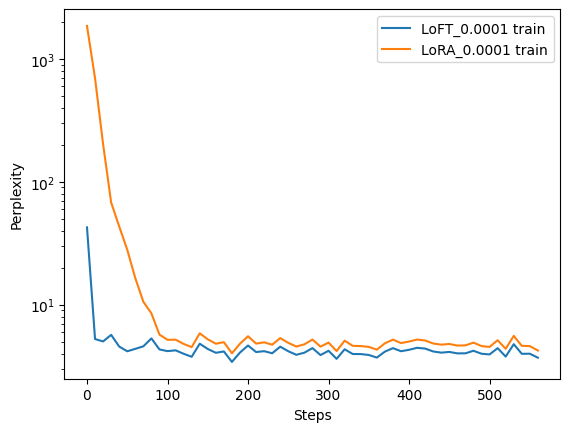

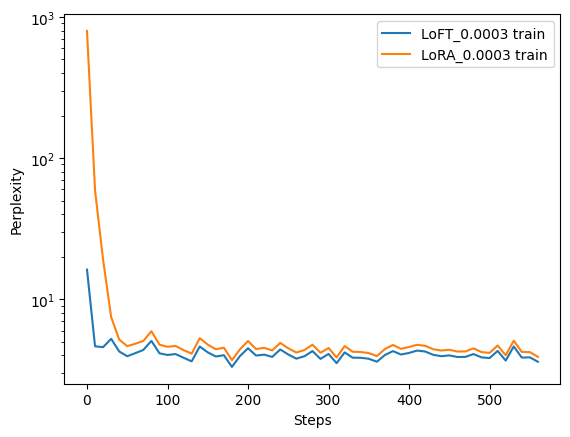

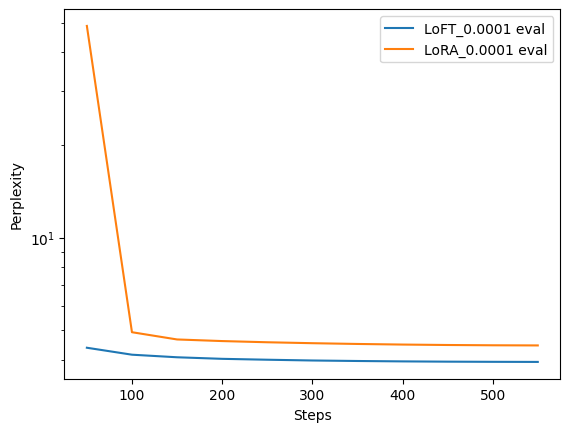

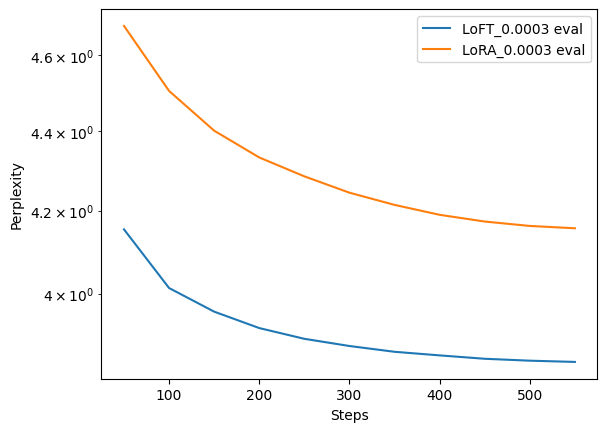

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# plot train losses
for name, loss in losses.items():
    lr = float(name.split("_")[1])
    if 'LoRA' in name:
        continue
    x_vals = np.arange(0, len(loss["train_loss"])) * logging_steps
    plt.plot(x_vals, np.exp(loss["train_loss"]), label=f"{name} train")
    loss_lora = losses[f"LoRA_{lr}"]["train_loss"]
    plt.plot(x_vals, np.exp(loss_lora), label=f"LoRA_{lr} train")
    plt.xlabel("Steps")
    plt.ylabel("Perplexity")
    plt.yscale("log")
    plt.legend()
    plt.show()

# plot eval losses
for name, loss in losses.items():
    lr = float(name.split("_")[1])
    if 'LoRA' in name:
        continue
    x_vals = np.arange(1, len(loss["eval_loss"]) + 1) * eval_steps
    plt.plot(x_vals, np.exp(loss["eval_loss"]), label=f"{name} eval")
    loss_lora = losses[f"LoRA_{lr}"]["eval_loss"]
    plt.plot(x_vals, np.exp(loss_lora), label=f"LoRA_{lr} eval")
    plt.xlabel("Steps")
    plt.ylabel("Perplexity")
    plt.yscale("log")
    plt.legend()
    plt.show()

